Loading data...

Cropping images...
Images were cropped from 208x176 to 176x144

Starting with no checkpoint...

Training...

Step: 1, Time: 00:01:33
Mean_train_loss:	13.998453140258789
Train_accuracy:		0.1618824452161789
Testing...
Mean_test_loss:		5.478909015655518
Test_accuracy:		0.35027363896369934

Actual\Predicted	NonD	VMildD	MildD	ModD
     NonDemented	0	640	0	0
VeryMildDemented	0	448	0	0
    MildDemented	0	179	0	0
ModerateDemented	0	12	0	0

Step: 2, Time: 00:03:00
Mean_train_loss:	5.569743633270264
Train_accuracy:		0.3118531405925751
Testing...
Mean_test_loss:		5.440174579620361
Test_accuracy:		0.17044566571712494

Actual\Predicted	NonD	VMildD	MildD	ModD
     NonDemented	0	124	516	0
VeryMildDemented	0	59	389	0
    MildDemented	0	20	159	0
ModerateDemented	0	0	12	0

Step: 3, Time: 00:04:45
Mean_train_loss:	5.547630310058594
Train_accuracy:		0.2446787804365158
Testing...
Mean_test_loss:		5.443392276763916
Test_accuracy:		0.009382329881191254

Actual\Predicted	NonD	VMildD	MildD	Mod

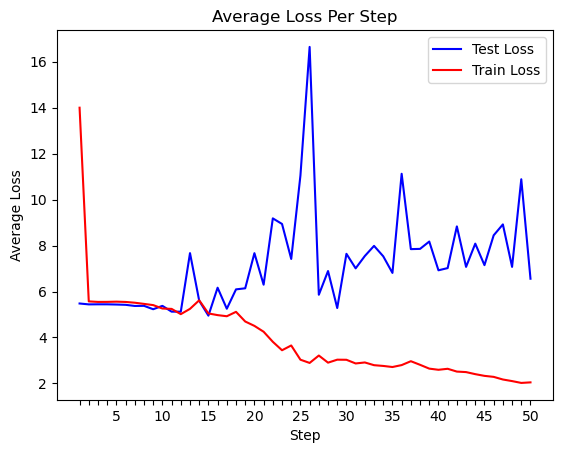

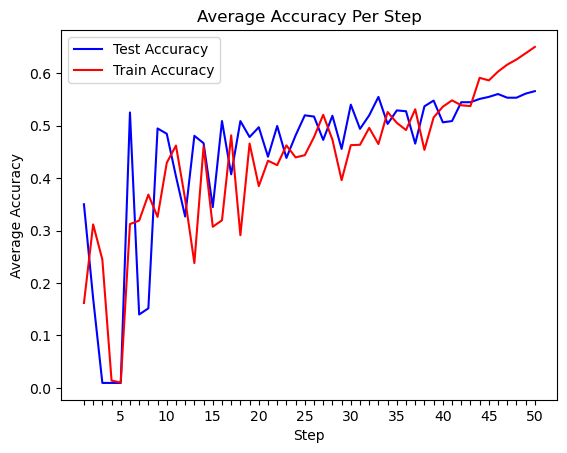

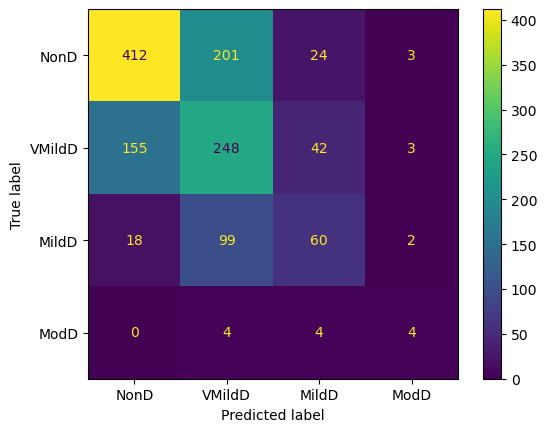

In [1]:
import os
import time
from model import *
from utils import *
import torch
import torch.nn as nn
from torch.optim import Adam
import csv

### SET PARAMETERS

# HYPERPARAMETERS
SEED            = 0
BATCH_SIZE      = 2048 # changed from 2048
LEARNING_RATE   = 0.001 # changed from 0.01
MAX_GRAD_NORM   = 2
MAX_STEPS       = 50
LOG_INTERVAL    = 1 # doesn't affect learning
RETAINED_VAR    = .90 # unused in current implementation of PCA
PCA_K           = 1024
WEIGHT_DECAY    = 0.001 # regularization parameter; changed from 0.001

# # MODEL PARAMETERS
# DIM_EMBED       = 16
# KERNEL_SIZE     = 3

# LOAD CHECKPOINT INFORMATION
CP_TIME         = ''
CP_STEP         = 0

### READ DATA
NUM_CLASS  = 4

print('Loading data...\n')
x_train, y_train, _ = read_data('train')
x_test,  y_test,  _ = read_data('test')

TRAIN_SIZE = x_train.shape[0]
TEST_SIZE  = x_test.shape[0]
NUM_CHANS  = x_train.shape[1]
NUM_ROWS   = x_train.shape[2]
NUM_COLS   = x_train.shape[3]

### PREPROCESS DATA
x_train, x_test = crop(x_train, x_test, threshold=0)
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

# x_train, x_test = pca(x_train, x_test, PCA_K)

### INITIALIZE MODEL
model = AlexNet(NUM_CLASS)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### INITIALIZE SAVE DIRECTORY
characteristics = f'version{3}'
time_id         = time.strftime('%Y-%m-%d %H-%M-%S')
save_dir        = os.path.join('results', characteristics, time_id)
os.makedirs(save_dir)

### LOAD CHECKPOINT
cp_path = os.path.join(characteristics, CP_TIME, f'{CP_STEP}.pt')
if os.path.isfile(cp_path):
    print('Loading checkpoint...\n')
    checkpoint = torch.load(cp_path)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
else:
    print('Starting with no checkpoint...\n')

### SET LOG WRITER
log_name = f'{characteristics}.csv'
log_path = os.path.join(save_dir, log_name)
with open(log_path, 'w', newline='') as f:
    header = ['Step', 'Mean_train_loss', 'Train_accuracy', 'Mean_test_loss', 'Test_accuracy']
    writer = csv.writer(f)
    writer.writerow(header)

### PREP FOR VISUALIZATION
highest_acc = 0
best_cm_args = ()

### TRAIN MODEL
print('Training...')
target_weights = 1.0 / torch.bincount(y_train)
start_time = time.time()
for epoch in range(1, MAX_STEPS + 1):
    model.train(True)
    loss_train = torch.empty((0))
    accuracy_train = torch.empty((0))
    shuffle = torch.randperm(TRAIN_SIZE)
    x_train_shuffled = x_train[shuffle]
    y_train_shuffled = y_train[shuffle]
    # y_train_onehot = y_train_onehot[shuffle]
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):
        logits = model(x_train_shuffled[i: i + BATCH_SIZE])
        loss = calc_loss(logits, y_train_shuffled[i: i + BATCH_SIZE])
        accuracy = calc_accuracy(logits, y_train_shuffled[i: i + BATCH_SIZE])
        
        ### APPEND LOSS AND ACCURACY
        if epoch % LOG_INTERVAL == 0:
            loss_train = torch.cat((loss_train, loss))
            accuracy_train = torch.cat((accuracy_train, accuracy))
    
        ### ACTOR UPDATE
        model_loss = loss.sum().view(1) # losses are summed instead of averaged for differing batch sizes
        optimizer.zero_grad()
        model_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()

    ### LOG
    if epoch % LOG_INTERVAL == 0:
        
        ### SAVE CHECKPOINT
        epoch_path = os.path.join(save_dir, f'{epoch}.pt')
        checkpoint = {}
        checkpoint['model'] = model.state_dict()
        checkpoint['optimizer'] = optimizer.state_dict()
        torch.save(checkpoint, epoch_path)
    
        ### START LOG
        end_time = time.time() - start_time
        print(f'\nStep: {epoch}, Time: {time.strftime("%H:%M:%S", time.gmtime(end_time))}')
        row = [epoch]
        
        ### LOG TRAIN LOSS AND ACCURACY
        print(f'Mean_train_loss:\t{loss_train.mean().item()}')
        print(f'Train_accuracy:\t\t{(accuracy_train.sum() / TRAIN_SIZE).item()}')
        row.append(loss_train.mean().item())
        row.append((accuracy_train.sum() / TRAIN_SIZE).item())
        
        ### TEST TRAINED MODEL
        print('Testing...')
        with torch.no_grad():
            model.train(False)
            logits = model(x_test)
            loss_test = calc_loss(logits, y_test)
            accuracy_test = calc_accuracy(logits, y_test)
            cm = calc_cm(logits, y_test)

            # Track best accuracy for CM
            acc_num = (accuracy_train.sum() / TRAIN_SIZE).item()
            if acc_num > highest_acc:
                highest_acc = acc_num
                best_cm_args = (logits, y_test)
            
        ### LOG TEST LOSS AND ACCURACY
        print(f'Mean_test_loss:\t\t{loss_test.mean().item()}')
        print(f'Test_accuracy:\t\t{(accuracy_test.sum() / TEST_SIZE).item()}')
        row.append(loss_test.mean().item())
        row.append((accuracy_test.sum() / TEST_SIZE).item())
        cm_visualize(cm)
        
        ### LOG
        with open(log_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(row)

print(f'\nTotal training time: {time.strftime("%H:%M:%S", time.gmtime(end_time))}')
final_visualize(log_path, best_cm_args)